In [1]:
#pip install cookiecutter
#!pip install yellowbrick
#!pip install umap-learn
#!pip install pandas-profiling[notebook]

# Solution Planning

In [2]:
# Input

1. Business Problem

    Selecting the most valuable customers to join a fidelization program

2. Data

    E-commerce sales during a year

In [3]:
# Output

1. List of customer will be part of insider program

    client_id  |  is_insider
     10323     |  yes

In [4]:
# Task

1. Quem são as pessoas elegíveis para participar do programa de Insiders ?
    - O que é ser elegivel? O que são clientes de maior 'valor'?
    - Faturamento:
        - Alto Ticket Médio
        - Alto LTV
        - Baixa recência
        - Alto basket size
        - Baixa probabilidade de churn
        - Alta previsão de LTV
        - Alta propensão de compra
        
    - Custo:
        - Baixa taxa de devolução
        
    - Experiencia de compra:
        - Média alta das avaliações
        
2. Quantos clientes farão parte do grupo?
    - Número total de clientes
    - % do grupo insiders
    
3. Quais as principais características desses clientes ?
    - Escrever características dos clientes:
        - Idade
        - Localização
        
    - Escrever características do consumo
        - Atributos de clusterizaçao

4. Qual a porcentagem de contribuição do faturamento, vinda do Insiders ?
    - Faturamento total do ano
    - Faturamento do grupo Insiders
    
    
5. Qual a expectativa de faturamento desse grupo para os próximos meses ?
    - LTV do grupo Insiders
    - Análise Cohort
    
6. Quais as condições para uma pessoa ser elegível ao Insiders ?
    - Definir a periodicidade (1 mes, 3 meses)
    - A pessoa precisa ser similar ou parecido com uma pessoa grupo
        
7. Quais as condições para uma pessoa ser removida do Insiders ?
    - Definir a periodicidade (1 mes, 3 meses)
    - A pessoa nao é ser similar ou parecido com uma pessoa grupo
    
8. Qual a garantia que o programa Insiders é melhor que o restante da base ?
    - Teste A/B
    - Teste A/B Bayesiano
    - Teste de hipóteses
    
9. Quais ações o time de marketing pode realizar para aumentar o faturamento?
    - Desconto
    - Preferencia de compra
    - Visita a empresa

Benchmark de soluções

# Imports

In [1]:
import re

import numpy             as np
import pandas            as pd
import seaborn           as sns
import umap.umap_        as umap
import statistics        as st

from sklearn             import mixture       as mx
from sklearn             import cluster       as c
from sklearn             import metrics       as m
from sklearn             import decomposition as dd
from plotly              import express       as px
from matplotlib          import pyplot        as plt
from sklearn             import preprocessing as pp
from sklearn             import ensemble      as en

from sklearn.manifold    import TSNE
from pandas_profiling    import ProfileReport
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

# Helper Functions

# Data Import

In [6]:
#load data
df = pd.read_csv('Ecommerce.csv',encoding="ISO-8859-1")

#drop
df = df.drop(columns=['Unnamed: 8'], axis=1)

# 1.0 Data Description

In [7]:
df1 = df.copy()

## 1.1. Rename Columns 

In [8]:
cols_new = df1.columns

cols_new = ['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date',
       'unit_price', 'customer_id', 'country']

df1.columns = cols_new

## 1.2. Data Dimensions

In [9]:
print('Number of columns: ', df1.shape[1])
print('Number of rows: ', df1.shape[0])

Number of columns:  8
Number of rows:  541909


## 1.3. Data Type

In [10]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## 1.4. NA Check

In [11]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## 1.5. Replace NA

In [12]:
df_missing = df1.loc[df1['customer_id'].isna(),:]
df_not_missing = df1.loc[~df1['customer_id'].isna(),:]

In [13]:
missing_invoice = df_missing['invoice_no'].drop_duplicates().tolist()

In [14]:
df_not_missing.loc[df_not_missing['invoice_no'].isin(missing_invoice),:].head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country


In [15]:
#create reference
df_backup = pd.DataFrame(df_missing['invoice_no'].drop_duplicates())
df_backup['customer_id'] = np.arange(19000, 19000+len(df_backup),1)

#merge
df1 = pd.merge(df1, df_backup, on='invoice_no', how='left')

#coalesce
df1['customer_id'] = df1['customer_id_x'].combine_first(df1['customer_id_y'])

#drop
df1 = df1.drop(columns=['customer_id_x','customer_id_y'],axis=1)

In [16]:
#df1 = df1.dropna(subset=['description', 'customer_id'])
#print('% dataset removed: {:.2f}'.format(1 - (df1.shape[0]/df.shape[0])))

## 1.6. Change Types

In [17]:
#df1['invoice_no'] = df1['invoice_no'].replace(to_replace='\D', value='', regex=True)
#df1['stock_code'] = df1['stock_code'].replace(to_replace='\D', value='0', regex=True)

In [18]:
#df1.loc[df1['stock_code'] == '85123A']
#df1 = df1.replace(['C536383','C536379','C536391','C536506'],['536383','536379','536391','536506'])

In [19]:
#invoice data
df1['invoice_date'] = pd.to_datetime(df1['invoice_date'], format= '%d-%b-%y')

#customer id
df1['customer_id'] = df1['customer_id'].astype(int)

#invoice no
#df1['invoice_no'] = df1['invoice_no'].astype(int)

#stock code
#df1['stock_code'] = df1['stock_code'].astype(int)

## 1.7. Descriptive Statistics

In [20]:
num_attributes = df1.select_dtypes(include = ['int64', 'float64'])
cat_attributes = df1.select_dtypes(include = ['int64', 'float64', 'datetime64[ns]'])

### 1.7.1. Numeric Attributes

In [21]:
#central tendency - mean, median, mode
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T
ct3 = pd.DataFrame(num_attributes.apply(st.mode)).T

#Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(min)).T
d2 = pd.DataFrame(num_attributes.apply(max)).T
d3 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d4 = pd.DataFrame(num_attributes.apply(np.std)).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

#concatenate
m = pd.concat([d1,d2,d3,ct1,ct2,ct3,d4,d5,d6]).T.reset_index()
m.columns = ['attributes','min','max','range','mean','median','mode','std','skew','kurtosis']
m

,attributes,min,max,range,mean,median,mode,std,skew,kurtosis
0,quantity,-80995.00,80995.0,161990.00,9.552250,3.00,1.00,218.080957,-0.264076,119769.160031
1,unit_price,-11062.06,38970.0,50032.06,4.611114,2.08,1.25,96.759764,186.506972,59005.719097


### 1.7.2. Categorical Attributes

In [22]:
#invoice no
df_letter_invoices = df1.loc[df1['invoice_no'].apply(lambda x: bool(re.search('[^0-9]+',x))),:]
df_letter_invoices.head()

print('Total number of invoices:{}'.format(len(df_letter_invoices)))
print('Total number of negatives quantity:{}'.format(len(df_letter_invoices[df_letter_invoices['quantity']<0])))

Total number of invoices:9291
Total number of negatives quantity:9288


In [23]:
#check stock code
df1.loc[df1['stock_code'].apply(lambda x: bool(re.search('^[a-zA-Z]+$',x))),'stock_code'].unique()

array(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY',
       'DCGSSGIRL', 'PADS', 'B', 'CRUK'], dtype=object)

In [24]:
#country
df1['country'].unique()

df1['country'].value_counts(normalize=True).head()

df1[['customer_id', 'country']].drop_duplicates().groupby('country').count().reset_index().sort_values('customer_id', ascending=False).head()

,country,customer_id
36,United Kingdom,7587
14,Germany,95
13,France,90
10,EIRE,44
31,Spain,31


In [25]:
#invoice
#len(cat_attributes.loc[cat_attributes['invoice_no'].apply(lambda x: bool(re.search('[^0-9]+',x))),'invoice_no'].drop_duplicates())

#stock code
#len(cat_attributes.loc[cat_attributes['stock_code'].apply(lambda x: bool(re.search('[^0-9]+',x))),'stock_code'])
#df1.loc[df1['stock_code'].apply(lambda x: bool(re.search('^[a-zA-Z]+$',x))),'stock_code'].unique()

#df1.loc[cat_attributes['stock_code'].apply(lambda x: bool(re.search('^[a-zA-Z]+$',x))),:].head()

# 2.0 Variable Filtering

In [26]:
df2 = df1.copy()

In [27]:
#numerical attributes 
#unit price
df2 = df2.loc[df2['unit_price'] > 0.04, :]

#stock code
df2 = df2[~df2['stock_code'].isin(['POST', 'D', 'M', 'DOT', 'CRUK', 'C2'])]
df2 = df2[~df2['stock_code'].isin(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY',
       'DCGSSGIRL', 'PADS', 'B', 'CRUK'])]

#desription
#df2 = df2.drop(columns='description', axis=1)

#map
df2 = df2[~df2['country'].isin(['European Community', 'Unspecified'])]

#bad user
df2 = df2[~df2['customer_id'].isin(16446)]

#quantity
df2_returns = df2.loc[df2['quantity'] < 0, :]
df2_purchase = df2.loc[df2['quantity'] > 0, :]

In [28]:
df2_purchase.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
country                 object
customer_id              int32
dtype: object

# 3.0 Feature Engineering

In [29]:
#df3 = df2.copy()

## 3.1. Feature Creation

In [30]:
#data ref
df_ref = df2.drop(['invoice_no', 'stock_code', 'description', 'quantity',
              'invoice_date', 'unit_price', 'country'], axis=1).drop_duplicates(ignore_index=True)

### 3.1.1. Gross Revenue

In [31]:
#gross revenue
df2_purchase.loc[:,'gross_revenue'] = df2_purchase.loc[:,'quantity'] * df2_purchase.loc[:,'unit_price']

#monetary
df_monetary = df2_purchase[['customer_id', 'gross_revenue']].groupby('customer_id').sum().reset_index()
df_ref = pd.merge(df_ref, df_monetary, how='left', on='customer_id')
df_ref.isna().sum()

C:\Users\Henrique\anaconda3\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


customer_id       0
gross_revenue    91
dtype: int64

### 3.1.2. Recency

In [32]:
#recency
df_recency = df2_purchase[['customer_id', 'invoice_date']].groupby('customer_id').max().reset_index()
df_recency['recency_days'] = (df2['invoice_date'].max() - df_recency['invoice_date']).dt.days
df_recency = df_recency[['customer_id', 'recency_days']].copy()
df_ref = pd.merge(df_ref, df_recency, on='customer_id', how='left')
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
dtype: int64

### 3.1.3. Quantity of purchased

In [33]:
#quantity of products
df_frequency = (df2_purchase[['customer_id','invoice_no']].drop_duplicates()
                                                         .groupby('customer_id')
                                                         .count()
                                                         .reset_index()
                                                         .rename(columns={'invoice_no':'quantity_invoices'}))
df_ref = pd.merge(df_ref, df_frequency, on='customer_id', how='left')
df_ref.isna().sum()

customer_id           0
gross_revenue        91
recency_days         91
quantity_invoices    91
dtype: int64

### 3.1.4. Quantity of items purchased

In [34]:
#quantity of products
df_frequency = (df2_purchase[['customer_id','quantity']].groupby('customer_id')
                                                       .sum()
                                                       .reset_index()
                                                       .rename(columns={'quantity':'quantity_items'}))
df_ref = pd.merge(df_ref, df_frequency, on='customer_id', how='left')
df_ref.isna().sum()

customer_id           0
gross_revenue        91
recency_days         91
quantity_invoices    91
quantity_items       91
dtype: int64

### 3.1.4. Quantity of products purchased

In [35]:
#quantity of products
df_frequency = (df2_purchase[['customer_id','stock_code']].groupby('customer_id')
                                                       .count()
                                                       .reset_index()
                                                       .rename(columns={'stock_code':'quantity_products'}))
df_ref = pd.merge(df_ref, df_frequency, on='customer_id', how='left')
df_ref.isna().sum()

customer_id           0
gross_revenue        91
recency_days         91
quantity_invoices    91
quantity_items       91
quantity_products    91
dtype: int64

### 3.1.5. Average ticket value

In [36]:
#avg ticket
df_avg_ticket = df2_purchase[['customer_id','gross_revenue']].groupby('customer_id').mean().reset_index().rename(
    columns={'gross_revenue':'avg_ticket'})
df_avg_ticket['avg_ticket'] = np.round(df_avg_ticket['avg_ticket'], 2) 
df_ref = pd.merge(df_ref,df_avg_ticket, on='customer_id', how='left')
df_ref.isna().sum()

customer_id           0
gross_revenue        91
recency_days         91
quantity_invoices    91
quantity_items       91
quantity_products    91
avg_ticket           91
dtype: int64

### 3.1.6. Average recency days

In [37]:
#average recency days
df_aux = df2[['customer_id', 'invoice_date']].drop_duplicates().sort_values(['customer_id', 'invoice_date'], 
                                                                            ascending=['False', 'False'])
df_aux['next_customer_id'] = df_aux['customer_id'].shift()
df_aux['previous_date'] = df_aux['invoice_date'].shift()

df_aux['avg_recency_days'] = df_aux.apply(lambda x: (x['invoice_date'] - x['previous_date']).
                                          days if x['customer_id'] == x['next_customer_id'] else np.nan, axis=1)

#drop
df_aux = df_aux.drop(['invoice_date', 'next_customer_id', 'previous_date'], axis=1).dropna()

#average recency
df_avg_recency_days = df_aux.groupby('customer_id').mean().reset_index()

#merge
df_ref = pd.merge(df_ref, df_avg_recency_days, on='customer_id', how='left')
df_ref.isna().sum()

customer_id             0
gross_revenue          91
recency_days           91
quantity_invoices      91
quantity_items         91
quantity_products      91
avg_ticket             91
avg_recency_days     2816
dtype: int64

### 3.1.7. Frequency

In [38]:
#df2_max = df2[['customer_id', 'invoice_date']].drop_duplicates().groupby('customer_id').max()
#df2_min = df2[['customer_id', 'invoice_date']].drop_duplicates().groupby('customer_id').min()
#df2_purchase = df2[['customer_id', 'invoice_date']].drop_duplicates().groupby('customer_id').count()

df_aux = (df2_purchase[['customer_id', 'invoice_no', 'invoice_date']].drop_duplicates()
                                                            .groupby('customer_id')
                                                            .agg(max_=('invoice_date', 'max'),
                                                                 min_=('invoice_date', 'min'),
                                                                 days_=('invoice_date', 
                                                                          lambda x: ((x.max() - x.min()).days)+1),
                                                                 buy_=('invoice_no','count'))).reset_index()

#frequency
df_aux['frequency'] = df_aux[['buy_','days_']].apply(lambda x: x['buy_']/x['days_'] if x['days_'] != 0 else 0, axis=1)

#merge
df_ref = pd.merge(df_ref, df_aux[['customer_id', 'frequency']], on='customer_id', how='left')

df_ref.isna().sum()

customer_id             0
gross_revenue          91
recency_days           91
quantity_invoices      91
quantity_items         91
quantity_products      91
avg_ticket             91
avg_recency_days     2816
frequency              91
dtype: int64

### 3.1.8. Number of returns

In [39]:
#number of returns
df_returns = df2_returns[['customer_id', 'quantity']].groupby(
    'customer_id').sum().reset_index().rename(columns={'quantity':'quantity_returns'})
df_returns['quantity_returns'] = df_returns['quantity_returns'] * -1

df_ref = pd.merge(df_ref, df_returns, how='left', on='customer_id')
df_ref.loc[df_ref['quantity_returns'].isna(), 'quantity_returns'] = 0

df_ref.isna().sum()


customer_id             0
gross_revenue          91
recency_days           91
quantity_invoices      91
quantity_items         91
quantity_products      91
avg_ticket             91
avg_recency_days     2816
frequency              91
quantity_returns        0
dtype: int64

### 3.1.9. Basket size - quantity of items per basket

In [40]:
df2_purchase.dtypes

invoice_no               object
stock_code               object
description              object
quantity                  int64
invoice_date     datetime64[ns]
unit_price              float64
country                  object
customer_id               int32
gross_revenue           float64
dtype: object

In [41]:
df_aux = (df2_purchase.loc[:, ['customer_id', 'invoice_no', 'quantity']].groupby('customer_id')
         .agg(n_purchase=('invoice_no', 'nunique'),
             n_products=('quantity', 'sum'))
         .reset_index())

df_aux.head()

#calculation
df_aux['avg_basket_size'] = df_aux['n_products'] / df_aux['n_purchase']

#merge
df_ref = pd.merge(df_ref, df_aux[['customer_id','avg_basket_size']], how='left', on='customer_id')
df_ref.isna().sum()

customer_id             0
gross_revenue          91
recency_days           91
quantity_invoices      91
quantity_items         91
quantity_products      91
avg_ticket             91
avg_recency_days     2816
frequency              91
quantity_returns        0
avg_basket_size        91
dtype: int64

### 3.1.10. Unique Basket size - quantity of items per basket

In [42]:
df_aux = (df2_purchase.loc[:, ['customer_id', 'invoice_no', 'stock_code']].groupby('customer_id')
         .agg(n_purchase=('invoice_no', 'nunique'),
             n_products=('stock_code', 'count'))
         .reset_index())

df_aux.head()

#calculation
df_aux['avg_unique_basket_size'] = df_aux['n_products'] / df_aux['n_purchase']

#merge
df_ref = pd.merge(df_ref, df_aux[['customer_id','avg_unique_basket_size']], how='left', on='customer_id')
df_ref.isna().sum()

customer_id                  0
gross_revenue               91
recency_days                91
quantity_invoices           91
quantity_items              91
quantity_products           91
avg_ticket                  91
avg_recency_days          2816
frequency                   91
quantity_returns             0
avg_basket_size             91
avg_unique_basket_size      91
dtype: int64

In [43]:
#number of returns
#df_returns = df2_returns[['customer_id', 'invoice_date']].drop_duplicates().groupby(
#    'customer_id').count().reset_index().rename(columns={'invoice_no':'retunrs'})
#df_ref = pd.merge(df_ref, df_returns, on='customer_id', how='left')
#df_ref.loc[df_ref['returns'].isna(),'returns'] = 0
#df_ref.isna().sum()

In [44]:
#df_ref = df3.drop(['invoice_no', 'stock_code', 'description', 'quantity',
#              'invoice_date', 'unit_price', 'country'], axis=1).drop_duplicates(ignore_index=True)

##gross revenue
#df3['gross_revenue'] = df3['quantity']*df3['unit_price']

##monetary
#df_monetary = df3[['customer_id', 'gross_revenue']].groupby('customer_id').sum().reset_index()
#df_ref = pd.merge(df_ref, df_monetary, on='customer_id', how='left')

##recency
#df_recency = df3[['customer_id', 'invoice_date']].groupby('customer_id').max().reset_index()
#df_recency['recency_days'] = (df3['invoice_date'].max() - df_recency['invoice_date']).dt.days
#df_recency = df_recency[['customer_id', 'recency_days']].copy()
#df_ref = pd.merge(df_ref, df_recency, on='customer_id', how='left')

##frequency
#df_freq = df3[['customer_id','invoice_no']].drop_duplicates().groupby('customer_id').count().reset_index()
#df_ref = pd.merge(df_ref, df_freq, on='customer_id', how='left')

##average ticket
#df_avg_ticket = df3[['customer_id','gross_revenue']].groupby('customer_id').mean().reset_index().rename(columns={
#    'gross_revenue':'avg_ticket'})
#df_ref = pd.merge(df_ref,df_avg_ticket, on='customer_id', how='left')
#df_ref.isna().sum()

# 4.0 EDA

In [45]:
df4 = df_ref.dropna()
df4.isna().sum()

customer_id               0
gross_revenue             0
recency_days              0
quantity_invoices         0
quantity_items            0
quantity_products         0
avg_ticket                0
avg_recency_days          0
frequency                 0
quantity_returns          0
avg_basket_size           0
avg_unique_basket_size    0
dtype: int64

## 4.1. Univariate Analysis

In [46]:
report = ProfileReport(df4)
report.to_file('output.html')

### 4.1.1. Average Ticket

In [ ]:
df3[df3['customer_id']==16446]

In [ ]:
df3[df3['customer_id']==16446]

### 4.1.2. Frequency

In [ ]:
df4[df4['frequency']==17]

### 4.1.3. Average Basket Size

In [ ]:
df4[df4['avg_basket_size']==40498.5]

## 4.2. Bivariate Analysis

In [46]:
cols = ['customer_id']
df42 = df4.drop(cols, axis=1)

<Figure size 1800x864 with 0 Axes>

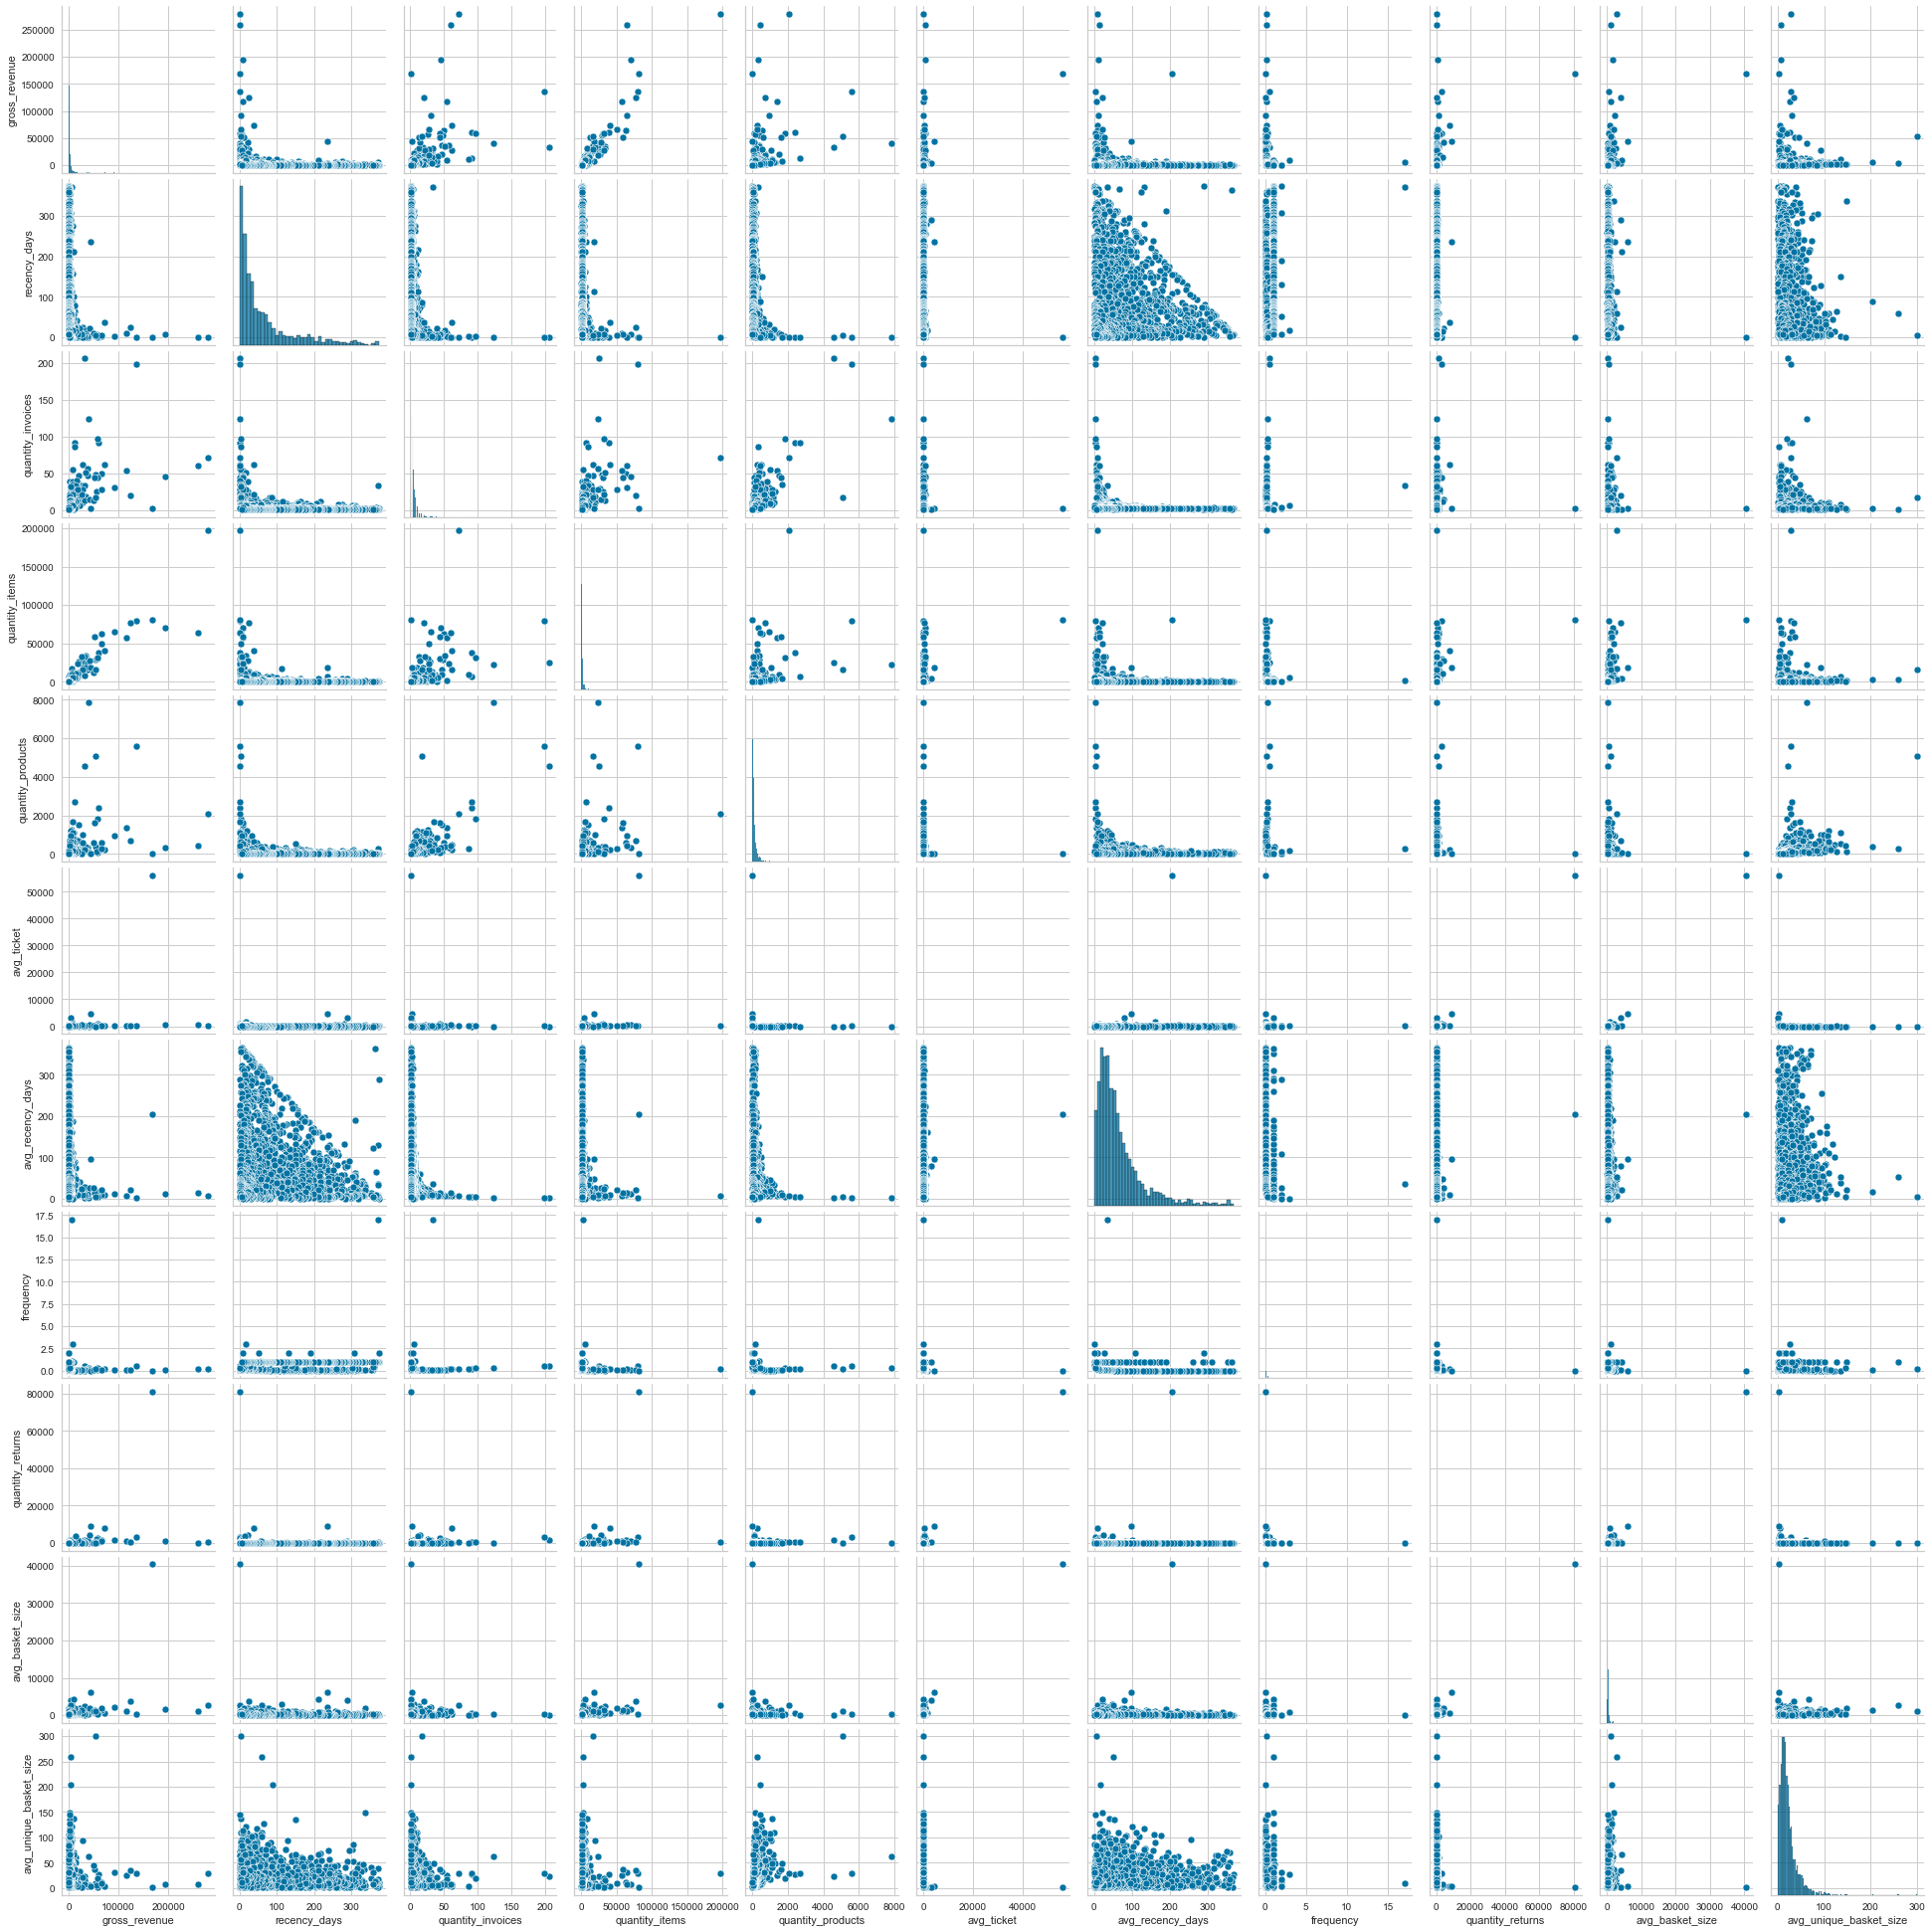

In [47]:
plt.figure(figsize=(25,12))
sns.pairplot(df42)

## 4.3. Space Study

In [66]:
df43 = df4.drop(columns=['customer_id'], axis=1).copy()

In [67]:
mm = pp.MinMaxScaler()

df43['gross_revenue'] = mm.fit_transform(df43[['gross_revenue']])
df43['recency_days'] = mm.fit_transform(df43[['recency_days']])
df43['quantity_invoices'] = mm.fit_transform(df43[['quantity_invoices']])
df43['quantity_items'] = mm.fit_transform(df43[['quantity_items']])
df43['quantity_products'] = mm.fit_transform(df43[['quantity_products']])
df43['avg_ticket'] = mm.fit_transform(df43[['avg_ticket']])
df43['avg_recency_days'] = mm.fit_transform(df43[['avg_recency_days']])
df43['frequency'] = mm.fit_transform(df43[['frequency']])
df43['quantity_returns'] = mm.fit_transform(df43[['quantity_returns']])
df43['avg_basket_size'] = mm.fit_transform(df43[['avg_basket_size']])
df43['avg_unique_basket_size'] = mm.fit_transform(df43[['avg_unique_basket_size']])

X = df43.copy()

### 4.3.1. PCA

In [68]:
X.shape[1]

11

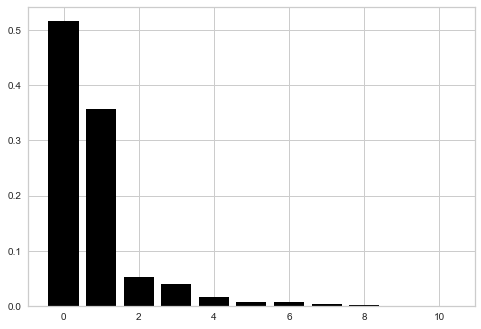

In [69]:
pca = dd.PCA(n_components=X.shape[1])

principal_components = pca.fit_transform(X)

#plot explained variable
features = range(pca.n_components_)

plt.bar(features, pca.explained_variance_ratio_, color='black')

#principal components
df_pca = pd.DataFrame(principal_components)

In [84]:
df_pca.columns

RangeIndex(start=0, stop=11, step=1)

In [87]:
#sns.scatterplot(data=df_pca, x=0, y=1)

### 4.3.2. UMAP

<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

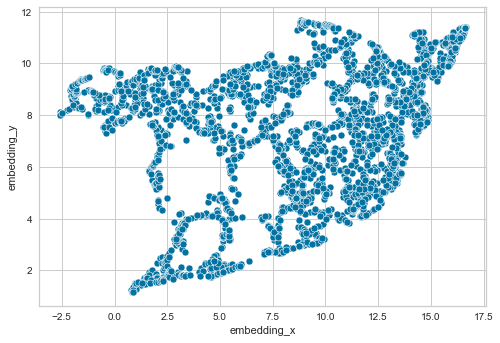

In [89]:
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(X)

#embedding
df_pca['embedding_x'] = embedding[:,0]
df_pca['embedding_y'] = embedding[:,1]

#plot UMAP
sns.scatterplot(x='embedding_x',
                y='embedding_y',
               data=df_pca)

### 4.3.2. TSNE

<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

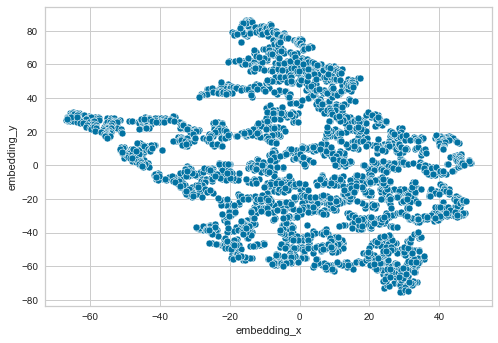

In [92]:
reducer = TSNE(n_components = 2, n_jobs=-1, random_state=42)
embedding = reducer.fit_transform(X)

#embedding
df_pca['embedding_x'] = embedding[:,0]
df_pca['embedding_y'] = embedding[:,1]

#plot TSNE
sns.scatterplot(x='embedding_x',
                y='embedding_y',
               data=df_pca)

### 4.3.2. TSNE

In [94]:
#training dataset
X = df4.drop(columns=['customer_id', 'gross_revenue'], axis=1)
y = df4['gross_revenue']

#model definition
rf_model = en.RandomForestRegressor(n_estimators=100, random_state=42)

#model training
rf_model.fit(X,y)

RandomForestRegressor(random_state=42)

In [95]:
df_leaf = pd.DataFrame(rf_model.apply(X))

<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

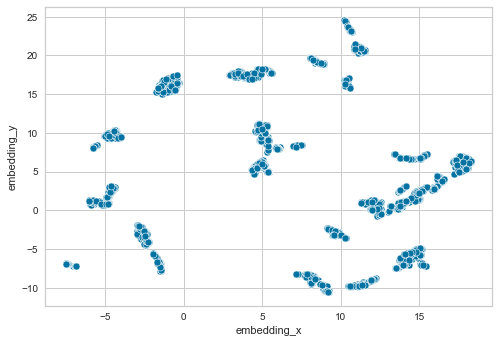

In [96]:
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(df_leaf)

#embedding
df_pca['embedding_x'] = embedding[:,0]
df_pca['embedding_y'] = embedding[:,1]

#plot UMAP
sns.scatterplot(x='embedding_x',
                y='embedding_y',
               data=df_pca)

# 5.0 Data Preparation

In [18]:
df5 = df4.copy()

In [ ]:
#ss = pp.StandardScaler()

#df5['gross_revenue'] = ss.fit_transform(df5[['gross_revenue']])
#df5['recency_days'] = ss.fit_transform(df5[['recency_days']])
#df5['invoice_date'] = ss.fit_transform(df5[['invoice_date']])
#df5['avg_ticket'] = ss.fit_transform(df5[['avg_ticket']])
#df5['returns'] = ss.fit_transform(df5[['returns']])

In [ ]:
mm = pp.MinMaxScaler()

df5['gross_revenue'] = mm.fit_transform(df5[['gross_revenue']])
df5['recency_days'] = mm.fit_transform(df5[['recency_days']])
df5['quantity_invoices'] = mm.fit_transform(df5[['quantity_invoices']])
df5['quantity_items'] = mm.fit_transform(df5[['quantity_items']])
df5['quantity_products'] = mm.fit_transform(df5[['quantity_products']])
df5['avg_ticket'] = mm.fit_transform(df5[['avg_ticket']])
df5['avg_recency_days'] = mm.fit_transform(df5[['avg_recency_days']])
df5['frequency'] = mm.fit_transform(df5[['frequency']])
df5['quantity_returns'] = mm.fit_transform(df5[['quantity_returns']])
df5['avg_basket_size'] = mm.fit_transform(df5[['avg_basket_size']])
df5['avg_unique_basket_size'] = mm.fit_transform(df5[['avg_unique_basket_size']])

# 6.0 Feature Selection

In [19]:
df6 = df5.copy()

In [20]:
print('Number of rows: ', df2.shape[0])

Number of rows:  406829


# 7.0 Hyperparameter Fine-Tuning

In [26]:
X = df6.drop(columns = 'customer_id')

clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10]

## 7.1. K-Means

In [3]:
kmean_list = []

for k in clusters:
    #model definition
    kmeans_model = c.KMeans(n_clusters=k)
    
    #model training
    kmeans_model.fit(X)
    
    #model predict
    labels = kmeans_model.predict(X)

    #model performance
    sil = m.silhouette_score(X, labels, metric='euclidean')
    kmeans_list.append(sil)

In [ ]:
plt.plot(clusters, kmeans_list, linestyle='--', marker='o',color='b')
plt.xlabel('K');
plt.ylabel('Silhouette Score');
plt.title('Silhouette Score vs K')

## 7.2. GMM

In [ ]:
gmm_list = []

for k in clusters:
    #model definition
    gmm_model = mx.GaussianMixture(n_components=k)
    
    #model training
    gmm_model.fit(X)
    
    #model predict
    labels = gmm_model.predict(X)
    
    #model performance
    sil = m.silhouette_score(X, labels, metric='euclidean')
    gmm_list.append(sil)

In [ ]:
plt.plot(clusters, gmm_list, linestyle='--', marker='o', color='b')
plt.xlabel('K');
plt.ylabel('Silhouette Score');
plt.title('Silhouette Score vs K')

## 7.5. Results

In [ ]:
df_results = pd.DataFrame(
                {'K-Means': kmeans_list,
                 'GMM': gmm_list}).T

df_results.columns = clusters

In [ ]:
df_results.style.highlight_max(color='lightgreen', axis=1)

## 7.1 Within-Cluster Sum of Square (WSS)

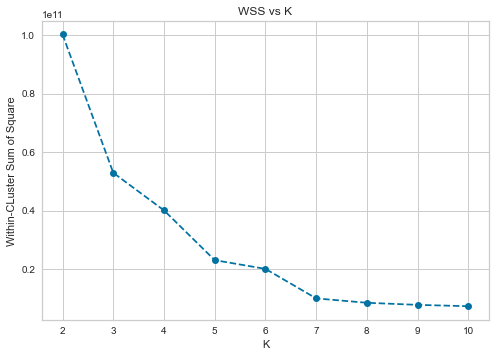

In [27]:
wss = []
for k in clusters:
    #model
    kmeans = c.KMeans(init='random', n_clusters=k, n_init=10, max_iter=300, random_state=42)
    
    #model training
    kmeans.fit(X)
    
    #validation
    wss.append(kmeans.inertia_)

#plot wss - Elbow Method
plt.plot(clusters, wss, linestyle='--', marker='o', color='b')
plt.xlabel('K');
plt.ylabel('Within-CLuster Sum of Square');
plt.title('WSS vs K');

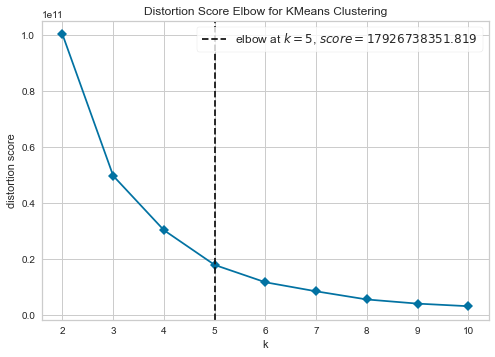

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [28]:
from yellowbrick.cluster import KElbowVisualizer

kmeans = KElbowVisualizer(c.KMeans(), k=clusters, timings = False)
kmeans.fit(X)
kmeans.show()

## 7.2. Silhouette Score (SS)

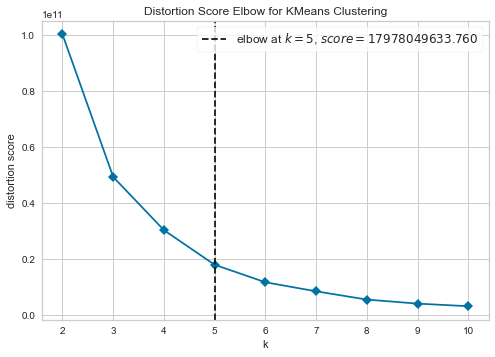

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [29]:
kmeans = KElbowVisualizer(c.KMeans(), k=clusters, metrics='silhouette', timings = False)
kmeans.fit(X)
kmeans.show()

## 7.2. Silhouette Analysis

IndexError: index 3 is out of bounds for axis 0 with size 3

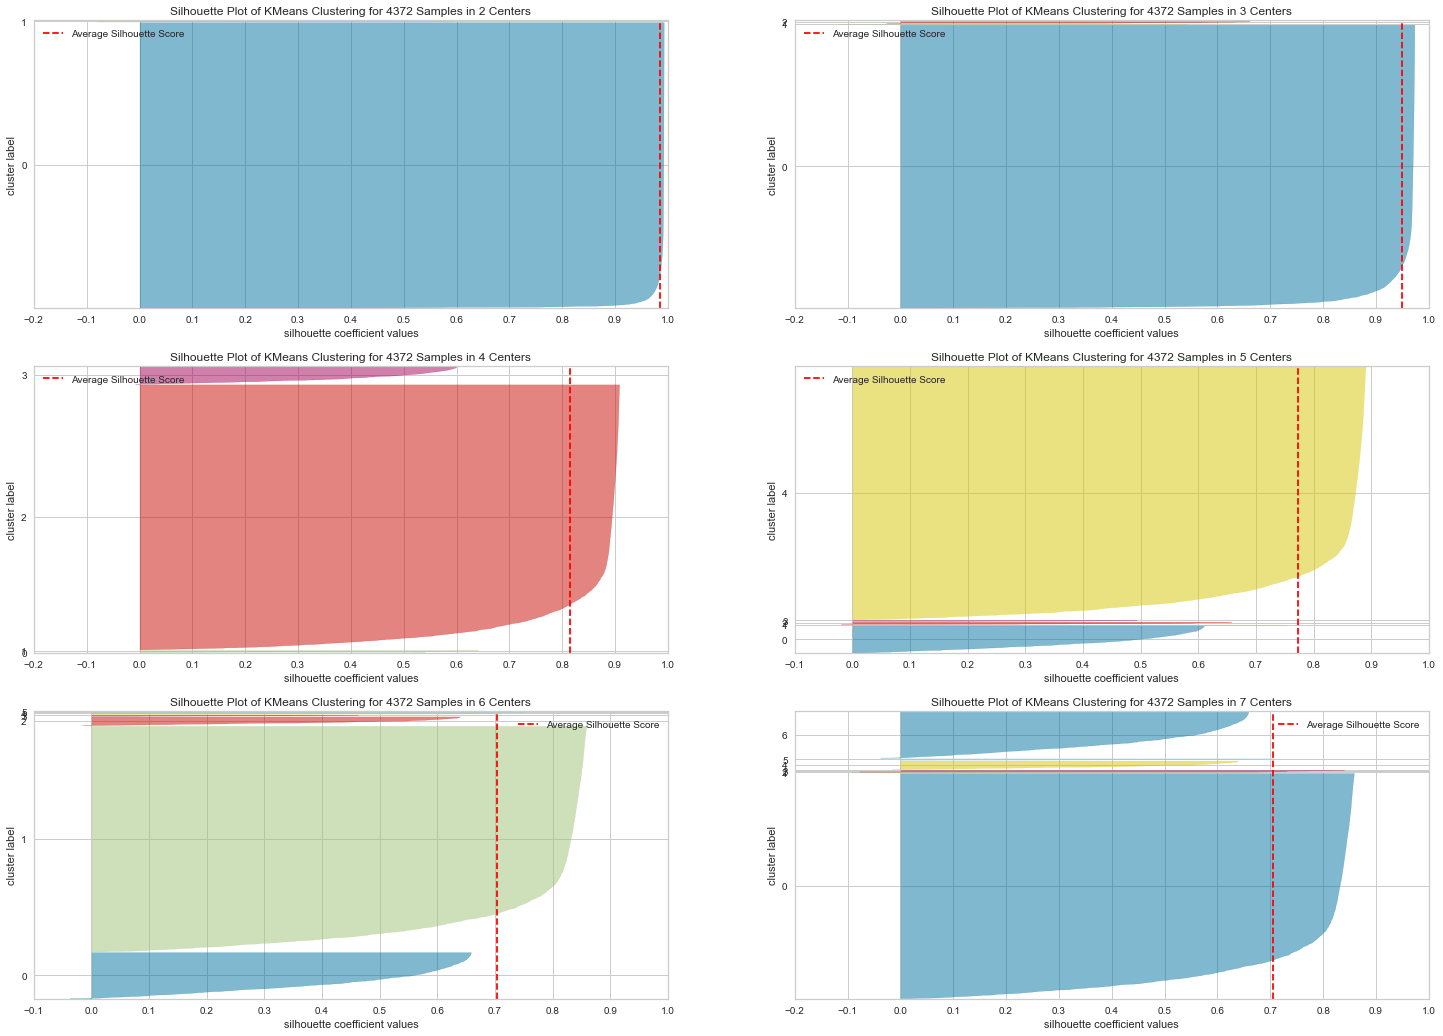

In [30]:
fig, ax = plt.subplots(3,2, figsize=(25,18))

for k in clusters:
    km = c.KMeans(n_clusters=k, init='random', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(k,2)
    
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(X)
    visualizer.finalize()

# 8.0 Model Training

## 8.1. K-Means

In [31]:
k = 4

#model
kmeans = c.KMeans(init='random', n_clusters=k, n_init=10, max_iter=300, random_state=42)
   
#model training
kmeans.fit(X)
    
#clustering
labels = kmeans.labels_

In [32]:
#WSS
print('WSS value: {}'.format(kmeans.inertia_))

#SS
print('SS value: {}'.format(m.silhouette_score(X, labels, metric='euclidean')))

WSS value: 40056254626.30001
SS value: 0.8139972028952444


# 9.0 Cluster Analysis

In [33]:
df9 = df6.copy()
df9['cluster'] = labels

## 9.1. Cluster Visualization

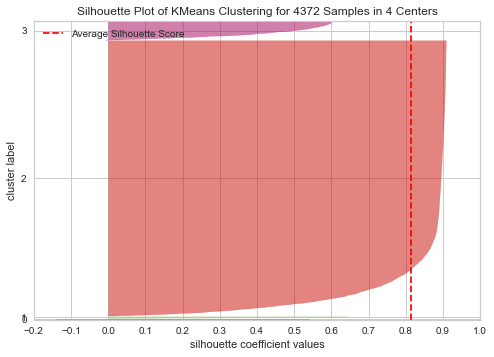

In [34]:
#fig = px.scatter_3d(df9, x='recency_days', y='invoice_no', z='gross_revenue', color='cluster')
#fig.show()

visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
visualizer.fit(X)
visualizer.finalize()

## 9.2. 2d

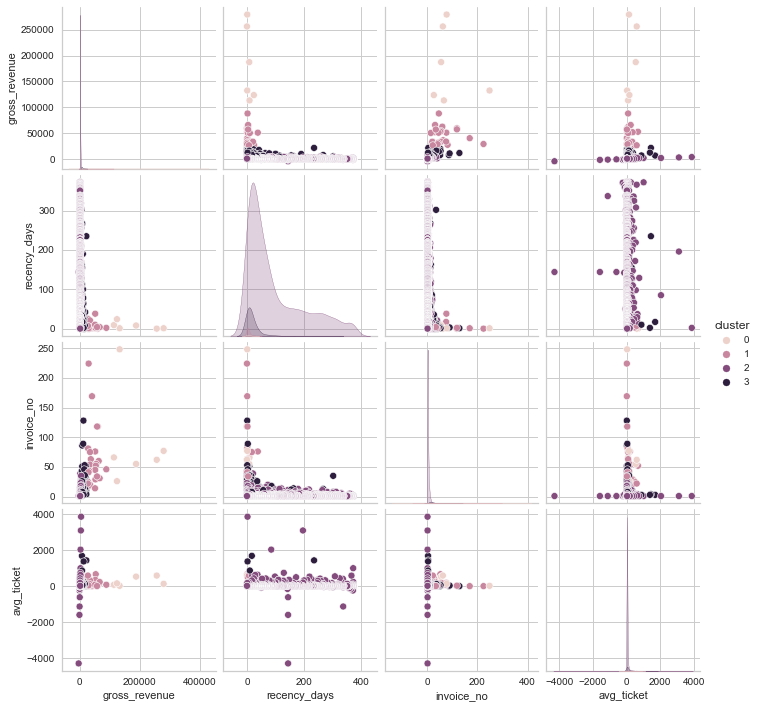

In [35]:
df_viz = df9.drop(columns='customer_id', axis=1)
sns.pairplot(df_viz, hue='cluster')

## 9.3. UMAP

<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

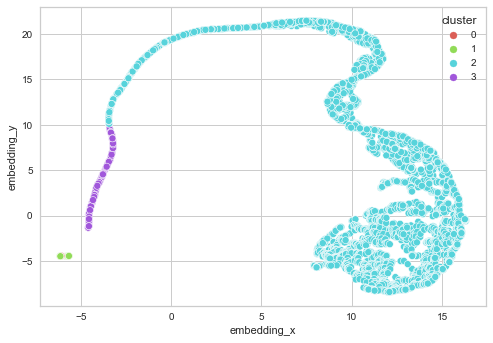

In [36]:
reducer = umap.UMAP(n_neighbors=20, random_state=42)
embedding = reducer.fit_transform(X)

#embedding
df_viz['embedding_x'] = embedding[:,0]
df_viz['embedding_y'] = embedding[:,1]

#plot UMAP
sns.scatterplot(x='embedding_x', y='embedding_y',
               hue='cluster',
               palette=sns.color_palette('hls', n_colors=len(df_viz['cluster'].unique())),
               data=df_viz)

## 9.4 Cluster Profile

In [38]:
#number of customer
df_cluster = df9[['customer_id','cluster']].groupby('cluster').count().reset_index()
df_cluster['perc_customer'] = 100*(df_cluster['customer_id']/df_cluster['customer_id'].sum())

#average gross revenue
df_avg_gross_revenue = df9[['gross_revenue','cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_gross_revenue, how='inner', on='cluster')

#average recency days
df_avg_recency_day = df9[['recency_days','cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_recency_day, how='inner', on='cluster')

#average invoice_no
df_avg_invoice_no = df9[['invoice_no','cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_invoice_no, how='inner', on='cluster')

#average ticket
df_avg_ticket = df9[['avg_ticket','cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_ticket, how='inner', on='cluster')

df_cluster

,cluster,customer_id,perc_customer,gross_revenue,recency_days,invoice_no,avg_ticket
0,0,6,0.137237,182181.981667,7.166667,89.000000,253.626345
1,1,28,0.640439,42614.387143,6.178571,57.821429,162.862605
2,2,4071,93.115279,946.696250,96.969295,3.641120,25.359654
3,3,267,6.107045,8089.028652,20.280899,19.528090,62.783157


# 3.0 Variable Filtering